In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import gamma as gamma_func
from scipy.stats import gamma, expon, norm
from tqdm.auto import tqdm
import arviz as az

%load_ext lab_black

# Gamma gamma

From [Unit 4: gammagamma.m](https://www2.isye.gatech.edu/isye6420/supporting.html).

Associated lecture videos: Unit 4 lessons 10 and 11.

Professor Vidakovic usually calls them credible sets. If you search for more information online, you'll see a lot of terms thrown around: Bayesian credible intervals, highest density regions, highest posterior density intervals (HDPI) or just highest density intervals (HDI), percentile intervals, and compatibility intervals. Not to be confused with confidence intervals!

These terms don't all mean exactly the same thing. For our class, the main distinction the professor draws is between HPD-credible sets and equitailed credible sets. Sometimes the homework will ask for one or the other, or both, so make sure you understand the difference. If the homework doesn't specify, you can use either, but the equitailed credible set is easier to calculate.

## Translation of MATLAB code (magic k)
First, here's a direct translation from the professor's MATLAB code. He didn't include how to find $k(\alpha)$ in this version.

In [3]:
def gamma_pdf(x, a, b):
    """
    Gamma pdf

    x: numpy array or float
    a: int or float. shape (α)
    b: int or float. rate (β)

    returns a numpy array or float
    """
    return 1 / gamma_func(a) * x ** (a - 1) * b**a * np.exp(-b * x)

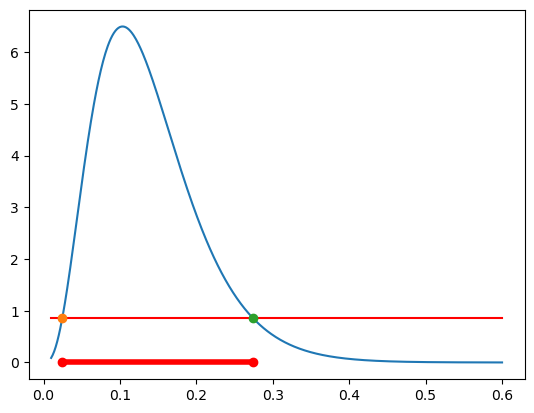

In [4]:
# figure 1

# unlike MATLAB i:j:k syntax, arange is not inclusive at the high end
xx = np.arange(0.01, 0.601, 0.001)
a = 4
b = 29

# curve
plt.plot(xx, gamma_pdf(xx, a, b))

# additional markings
plt.plot(xx, np.full_like(xx, 0.857), "r-")
plt.plot(0.0246, gamma_pdf(0.0246, a, b), "o")
plt.plot(0.0246, 0, "ro")
plt.plot(0.2741, gamma_pdf(0.2741, a, b), "o")
plt.plot(0.2741, 0, "ro")
plt.plot([0.0246, 0.2741], [0, 0], "r-", linewidth=4)
plt.show()

In [5]:
# hpd credible set

k = 0.857368863848

lower_hpd = fsolve(lambda x: gamma_pdf(x, a, b) - k, 0.05)[0]
upper_hpd = fsolve(lambda x: gamma_pdf(x, a, b) - k, 0.4)[0]
print(f"HPD credible set: [{lower_hpd} {upper_hpd}]")

prob_hpd = gamma.cdf(upper_hpd, a, scale=1 / b) - gamma.cdf(lower_hpd, a, scale=1 / b)
print(f"Probability within hpd bounds: {prob_hpd}")
print(f"length of hpd cs: {upper_hpd - lower_hpd}")

HPD credible set: [0.024568994513107345 0.27407917790064784]
Probability within hpd bounds: 0.9500000000000202
length of hpd cs: 0.2495101833875405


In [6]:
# equi-tailed credible set

# percent point function aka inverse cdf
lower_eqt = gamma.ppf(0.025, a, scale=1 / b)
upper_eqt = gamma.ppf(0.975, a, scale=1 / b)
print(f"Equitailed credible set: [{lower_eqt} {upper_eqt}]")

prob_eqt = gamma.cdf(upper_eqt, a, scale=1 / b) - gamma.cdf(lower_eqt, a, scale=1 / b)
print(f"Probability within eqt bounds: {prob_eqt}")
print(f"length of eqt cs: {upper_eqt - lower_eqt}")

Equitailed credible set: [0.037581564607804305 0.3023197610255974]
Probability within eqt bounds: 0.95
length of eqt cs: 0.26473819641779306


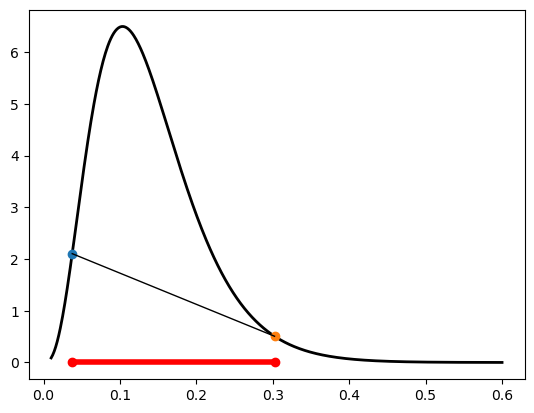

In [7]:
# figure 2

# curve
plt.plot(xx, gamma_pdf(xx, a, b), "k-", linewidth=2)

plt.plot(lower_eqt, gamma_pdf(lower_eqt, a, b), "o")
plt.plot(lower_eqt, 0, "ro")
plt.plot(upper_eqt, gamma_pdf(upper_eqt, a, b), "o")
plt.plot(upper_eqt, 0, "ro")
plt.plot([lower_eqt, upper_eqt], [0, 0], "r-", linewidth=4)
plt.plot(
    [lower_eqt, upper_eqt],
    [gamma_pdf(lower_eqt, a, b), gamma_pdf(upper_eqt, a, b)],
    "k-",
    linewidth=1,
)
plt.show()

## Find the HPD credible interval when you don't know k

A student in the Spring 2022 class was wondering where the .05 and .4 values entered to ```fsolve()``` came from. They're just your guesses for the lower and upper bounds of the credible interval. They give the optimizer a starting point.

That led to the bigger question of where $k$ came from. What you need to find is the output of $k(α)$, which is a horizontal line that intersects the posterior PDF at the lower and upper bounds of your HPD credible interval. The reason we want a horizontal line is that this ensures that you've got the shortest interval covering credibility $1 - α$ (we usually choose a credibility of .95 in this course, but that's arbitrary).

I don't know how the professor did it originally, but here are two approaches to estimate the HPD interval. Both assume that the posterior is unimodal, but could be extended to account for multimodal cases.

### Optimization method
First, an optimization method, pretty much just trying lots of values for $k$ (this was how the head TA did it when I took this course):

1. Loop over a bunch of possible k values, each time using an equation like fzero() on the pdf of your posterior minus k. This will solve for the location that your pdf intersects with k. You need to feed the optimizer an initial guess, one lower, near the lower bound of the credible interval, and one higher, near the upper bound.

2. Enter each bound into the posterior CDF, subtract the results to get the probability the posterior falls within those bounds. If it's close enough to 1 - α, you can stop the loop because you have your answer. If not, the loop continues.

In [8]:
# Finding the HPD credible set

# our pdf is Gamma(4, 1/29) where 29 is the rate.
# looking at the plot, k must be between 0-2

a = 4
b = 29
alpha = 0.05
tolerance = 0.0001
iterations = 20000

# initial guesses
guess_lwr = 0.05
guess_upr = 0.4
possible_k = np.linspace(0, 2, iterations)
success = 0
# if loop finishes without printing anthing, no solution within given tolerance
# solution: adjust tolerance, initial guesses, range of possible_k
for k in tqdm(possible_k):
    lower = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_lwr)[0]
    upper = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_upr)[0]
    prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)
    if abs(prob - (1 - alpha)) <= tolerance:
        success = 1
        break

assert success == 1, "Credible set within given tolerance not found!"

print(f"{k=}")
print(f"HPD credible set: {lower, upper}")
print(f"length = {upper - lower}")
print(f"probability within these bounds: {prob}")

Output()

/Users/aaron/mambaforge/envs/pymc_env2/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: 
RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

k=0.855942797139857
HPD credible set: (0.02455112335043536, 0.2741713733854568)
length = 0.24962025003502142
probability within these bounds: 0.950094289217813


This brute-force method is really finicky, you might find yourself needing to adjust the tolerance and initial guesses quite a bit. It helps to base your guesses off visual inspection of a plot of the posterior.
### Better optimization method
But we can do better! Instead of trying a bunch of different guesses for k, solve for where two conditions are met:

1. The pdf must evaluate to the same density at each bound (so k is horizontal).
2. The probability within those bounds must be equal to 1 - alpha.

In [8]:
guess_lwr = 0.05
guess_upr = 0.4


def conditions(x):
    a = 4
    b = 29
    alpha = 0.05
    lwr, upr = x

    cond_1 = gamma.pdf(upr, a, scale=1 / b) - gamma.pdf(lwr, a, scale=1 / b)
    cond_2 = (
        gamma.cdf(upr, a, scale=1 / b) - gamma.cdf(lwr, a, scale=1 / b) - (1 - alpha)
    )

    return cond_1, cond_2


fsolve(conditions, (guess_lwr, guess_upr))

array([0.02456899, 0.27407918])

### Sampling method

"Working with samples transforms a problem in calculus into a problem in data summary, into a frequency format problem. An integral in a typical Bayesian context is just the total probability in some interval. That can be a challenging calculus problem. But once you have samples from the probability distribution, it’s just a matter of counting values in the interval."

- Richard McElreath (Chapter 3, *Statistical Rethinking*)

There's another way that I find simpler, which involves sampling lots of values from the posterior. This is also the way it's generally done in practice, since using MCMC we'll only be getting samples from the posterior anyways. See the source code for hpd or hdi functions in many Bayesian libraries like [Arviz](https://arviz-devs.github.io/arviz/_modules/arviz/stats/stats.html#hdi) or [MCMCChains.jl](https://github.com/TuringLang/MCMCChains.jl/blob/master/src/stats.jl).

This method is simplified - it won't work for as many different cases as the ones in those packages, but it's easier to understand.

1. Draw some samples from your posterior.
2. Sort them from smallest to largest.
3. Compute the possible credible intervals.
4. Take the one with the minimum width.

See [Chen and Shao, 1999](https://www.jstor.org/stable/1390921) for the math.

In [9]:
def calc_hdi(samples: np.ndarray, alpha: float = 0.05) -> tuple:
    """
    Calculate minimum-width credible interval (HPD credible set)

    samples: samples from posterior
    alpha: credibility of the interval == 1 - alpha

    returns tuple of the lower and upper bounds of the interval
    """
    n = len(samples)
    x = np.sort(samples)

    lower_idx = int(np.floor(alpha * n))
    x_left = x[:lower_idx]
    x_right = x[n - lower_idx :]

    idx = np.argmin(x_right - x_left)

    upper_bound = x_right[idx]
    lower_bound = x_left[idx]

    return lower_bound, upper_bound


a = 4
b = 29

samples = gamma.rvs(a, scale=1 / b, size=1000000)
lower, upper = calc_hdi(samples, alpha=0.05)
# double-check credibility
prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)

print(f"HPD credible set: {lower, upper}")
print(f"length = {upper - lower}")
print(f"probability within these bounds: {prob}")

HPD credible set: (0.024626593548406673, 0.27382656615789086)
length = 0.24919997260948418
probability within these bounds: 0.9497334078776606


In [10]:
# use np.quantile for equitailed credible sets

a = 4
b = 29
n = 1000000
samples = gamma.rvs(a, scale=1 / b, size=n)

x = np.sort(samples)
alpha = 0.05

lower_idx = int(np.floor(alpha / 2 * n))
upper_idx = int(np.floor((1 - alpha / 2) * n))

print(f"manual = {x[lower_idx], x[upper_idx]}")

np.quantile(samples, (0.025, 0.975))

manual = (0.03766380616650337, 0.3021321651913597)


array([0.0376638 , 0.30213107])

## Additional examples

The previous example goes over HPD and equi-tailed credible intervals for a gamma distribution. With a known distribution, you can use the inverse cdf for equi-tailed and the optimization method for the HPD set. 

But you need to be careful with the optimization method, you can't always plug in every posterior to that function and get the right answer.

### Exponential distribution

This distribution is monotonically decreasing. How does that affect our credible interval calculations?

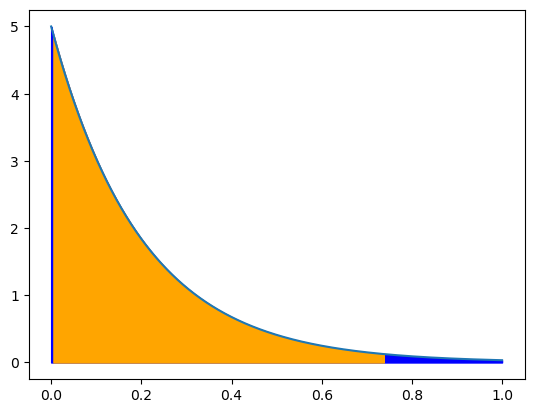

0.0051, 0.7378


In [11]:
xx = np.linspace(0, 1, 1000000)
pdf = expon.pdf(xx, scale=0.2)

# equitailed
low, high = expon.ppf(0.025, scale=0.2), expon.ppf(0.975, scale=0.2)

plt.plot(xx, pdf)
plt.fill_between(xx, pdf, color="blue")
plt.fill_between(xx, pdf, where=(low < xx) & (xx < high), color="orange")

plt.show()
print(f"{low:.4f}, {high:.4f}")

By definition, the equi-tailed credible interval must leave the same density out on both sides (the blue in the plot above). But clearly this is not a great representation of the distribution.

Someone in the Fall 2022 semester asked how to use the $k(\alpha)$ method to get the HPD credible set of an exponential distribution. Remember that making use of a horizontal line is not part of the definition of an HPD credible interval. It's also called the minimum-width credible set, being the shortest credible interval that satisfies the given alpha value. But there's no way to get k when the function is monotonic.

In this case, we can see that the left endpoint must be zero.

In [12]:
upper_guess = 0.75


def conditions(x):
    alpha = 0.05
    cond = expon.cdf(x, scale=0.2) - (1 - alpha)

    return cond


upper = fsolve(conditions, upper_guess)[0]

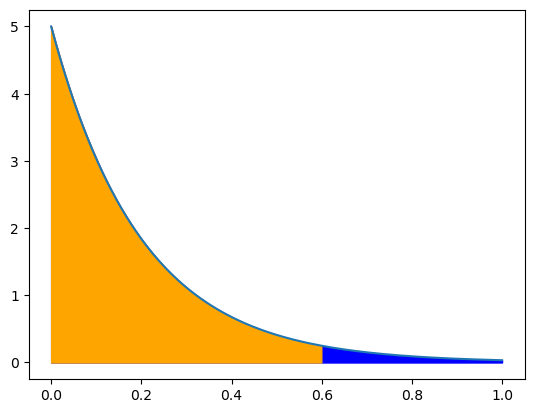

0, 0.5991


In [13]:
plt.plot(xx, pdf)
plt.fill_between(xx, pdf, color="blue")
plt.fill_between(xx, pdf, where=(0 < xx) & (xx < upper), color="orange")
plt.show()
print(f"0, {upper:.4f}")

In [14]:
calc_hdi(expon.rvs(scale=0.2, size=1000000))

(3.393968041482104e-08, 0.6005978377919483)

### Mixtures and multimodal distributions

What if we have a posterior where we don't have all these nice builtin functions like the inverse cdf?

For example, a mixture of two distributions.

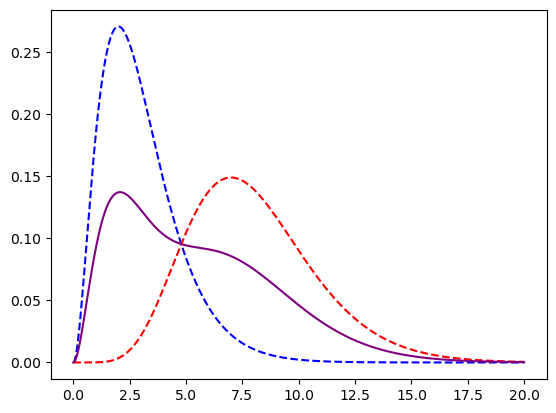

In [15]:
xx = np.linspace(0, 20, 1000000)

dist1 = gamma(a=3, scale=1)
dist2 = gamma(a=8, scale=1)

plt.plot(xx, dist1.pdf(xx), linestyle="dashed", color="blue")
plt.plot(xx, dist2.pdf(xx), linestyle="dashed", color="red")
plt.plot(xx, 0.5 * dist1.pdf(xx) + 0.5 * dist2.pdf(xx), color="purple")
plt.show()

We could easily go the sampling route still.

In [16]:
ct = 10000000
samples = np.append(dist1.rvs(size=int(ct * 0.5)), dist2.rvs(size=int(ct * 0.5)))

print(f"hdi={calc_hdi(samples)}")
print(f"eqt={np.quantile(samples, [.025, .975])}")

hdi=(0.3597408071155166, 11.914954113823958)
eqt=[ 0.81652412 13.15528411]


What about multimodal?

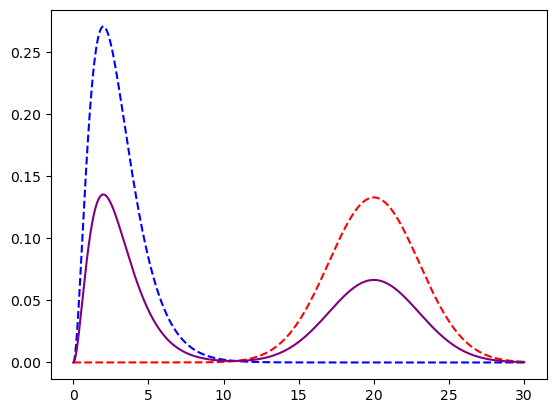

In [17]:
xx = np.linspace(0, 30, 1000000)


dist1 = gamma(a=3, scale=1)
dist2 = norm(loc=20, scale=3)

plt.plot(xx, dist1.pdf(xx), linestyle="dashed", color="blue")
plt.plot(xx, dist2.pdf(xx), linestyle="dashed", color="red")
plt.plot(xx, 0.5 * dist1.pdf(xx) + 0.5 * dist2.pdf(xx), color="purple")
plt.show()

In [18]:
samples = np.append(dist1.rvs(size=int(ct * 0.5)), dist2.rvs(size=int(ct * 0.5)))

Our calc_hdi function doesn't give a very useful answer.

In [19]:
calc_hdi(samples)

(0.40751403085099935, 23.99196781935934)

Neither does the equi-tailed credible set.

In [20]:
np.quantile(samples, [0.025, 0.975])

array([ 0.81746069, 24.93705573])

Instead use the Arviz [```hdi```](https://python.arviz.org/en/stable/api/generated/arviz.hdi.html) function with the multimodal argument or your favorite equivalent.

In [21]:
az.hdi(samples, hdi_prob=0.95, multimodal=True)

array([[ 0.25925264,  6.99371493],
       [14.36617891, 25.63754211]])

In [22]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Thu Feb 02 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

matplotlib: 3.6.2
arviz     : 0.13.0
numpy     : 1.23.4

